In [26]:
# import all libraries

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd

from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
# creation of train, validation and test folders

import os
import random
from shutil import copyfile

def img_train_test_split(img_source_dir, train_size, validation_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('../data'):
        os.makedirs('../data')
    else:
        if not os.path.exists('../data/train'):
            os.makedirs('../data/train')
        if not os.path.exists('../data/validation'):
            os.makedirs('../data/validation')
        if not os.path.exists('../data/test'):
            os.makedirs('../data/test')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('../data/train', subdir)
        validation_subdir = os.path.join('../data/validation', subdir)
        test_subdir = os.path.join('../data/test', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)
            
        if not os.path.exists(test_subdir):
            os.makedirs(test_subdir)

        train_counter = 0
        validation_counter = 0
        test_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                elif random.uniform(0, 1) <= validation_size:
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                else :
                    copyfile(os.path.join(subdir_fullpath, filename),
                             os.path.join(test_subdir, str(test_counter) + '.' + fileparts[1]))
                    test_counter += 1
                    

img_train_test_split('../data/Images', 0.7, 0.4)

In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../data/train')
valid_files, valid_targets = load_dataset('../data/validation')
test_files, test_targets = load_dataset('../data/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../data/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 120 total dog categories.
There are 20580 total dog images.

There are 14443 training dog images.
There are 2417 validation dog images.
There are 3720 test dog images.


In [21]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
from keras.applications import ResNet50
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model, Sequential

pretrained_model= ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3)) 

for layer in pretrained_model.layers:
    layer.trainable = False
    
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
#dropout
predictions = Dense(120, activation='softmax')(x)

model = Model(inputs = pretrained_model.input, outputs=predictions) 

base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/home/bayet/.virtualenvs/py3cv4/lib/python3.5/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [5]:
# training image augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from keras.callbacks import History 
from keras.applications import vgg16

batch_size = 16

# this is the augmentation configuration I will use for training
train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=vgg16.preprocess_input)

# This is the augmentation configuration I will use for testing/validation... just a rescale
test_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

# This is the generator which will read pictures found in my training subset
train_generator = train_datagen.flow_from_directory('../data/train/',
                                                    target_size = (224, 224),
                                                    batch_size = batch_size,
                                                    shuffle=True,
                                                    class_mode = 'categorical',
                                                    seed=42)

# This is the generator for validation data
validation_generator = test_datagen.flow_from_directory('../data/validation/',
                                                        target_size = (224, 224),
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical')

Found 14443 images belonging to 120 classes.
Found 2417 images belonging to 120 classes.


In [13]:
test_generator = test_datagen.flow_from_directory('../data/test/',
                                                        target_size = (224, 224),
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical')

Found 3720 images belonging to 120 classes.


In [8]:
from keras.callbacks import ModelCheckpoint, History

history = History()
checkpoint_augmentation = '../data/checkpoint_augmentation'
model_checkpoint_augmentation = ModelCheckpoint(filepath=checkpoint_augmentation,
                                                verbose=1,
                                                save_best_only=True)

In [9]:
%%time
model.fit_generator(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    callbacks = [model_checkpoint_augmentation, history],
                    verbose=2)

Epoch 1/10
 - 1982s - loss: 1.9770 - accuracy: 0.4857 - val_loss: 9.0714e-05 - val_accuracy: 0.6984

Epoch 00001: val_loss improved from inf to 0.00009, saving model to ../data/checkpoint_augmentation
Epoch 2/10
 - 1940s - loss: 1.2010 - accuracy: 0.6452 - val_loss: 0.0016 - val_accuracy: 0.7100

Epoch 00002: val_loss did not improve from 0.00009
Epoch 3/10
 - 1900s - loss: 1.0549 - accuracy: 0.6831 - val_loss: 0.5171 - val_accuracy: 0.7182

Epoch 00003: val_loss did not improve from 0.00009
Epoch 4/10
 - 1922s - loss: 0.9860 - accuracy: 0.6992 - val_loss: 0.0084 - val_accuracy: 0.7009

Epoch 00004: val_loss did not improve from 0.00009
Epoch 5/10
 - 1904s - loss: 0.9274 - accuracy: 0.7219 - val_loss: 8.3446e-07 - val_accuracy: 0.7249

Epoch 00005: val_loss improved from 0.00009 to 0.00000, saving model to ../data/checkpoint_augmentation
Epoch 6/10
 - 1916s - loss: 0.8267 - accuracy: 0.7483 - val_loss: 5.8638 - val_accuracy: 0.7182

Epoch 00006: val_loss did not improve from 0.00000
Ep

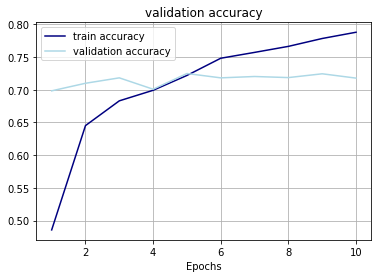

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

t = np.linspace(1, len(acc), len(acc)).flatten()
plt.plot(t, acc, 'navy', label='train accuracy')
plt.plot(t, val_acc, 'lightblue', label='validation accuracy')

plt.grid(True)
plt.xlabel('Epochs')
plt.title('validation accuracy')
plt.legend(loc=2)
plt.show();

In [14]:
resnet_test_accuracy = model.evaluate_generator(test_generator, steps= len(test_generator.classes) // 16)[1]

In [15]:
model_stats = {
    'models': [],
    'accuracy': [],
    'test_accuracy': [],
    'epoch_training_time': [],
    'inference_time_10000pic': []
}

In [18]:
from keras.applications.resnet import ResNet50

model_stats['models'].append('Resnet50')

#Accuracy & validation accuracy
acc = history.history['accuracy'][-1]
model_stats['accuracy'].append(acc * 100)
model_stats['test_accuracy'].append(resnet_test_accuracy * 100)


#Print results
print('Accuracy: %0.1f%% / Test accuracy: %0.1f%%' %(acc*100, resnet_test_accuracy*100))


Accuracy: 78.8% / Test accuracy: 69.6%


In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, plot_values=False, printed=False,
                          title='Confusion matrix',
                          figsize=(20,20), cmap=plt.cm.Blues, rotation_xticks=90):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    if printed:
        print(cm)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=rotation_xticks)
    plt.yticks(tick_marks, classes)

    if plot_values:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            val = format(cm[i, j], fmt)
            val = int(float(val)) if (float(val) >= 1.) else val
            if float(val):
                plt.text(j, i, val,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [32]:
gen_iter = len(test_generator.classes) // 16

y_pred = model.predict_generator(test_generator, gen_iter)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_generator.classes
y_true = y_true[:y_pred.shape[0]]

In [35]:
dog_breeds = test_generator.class_indices
dog_breeds = [k for k in dog_breeds.keys()]
dog_breeds.sort()

Normalized confusion matrix


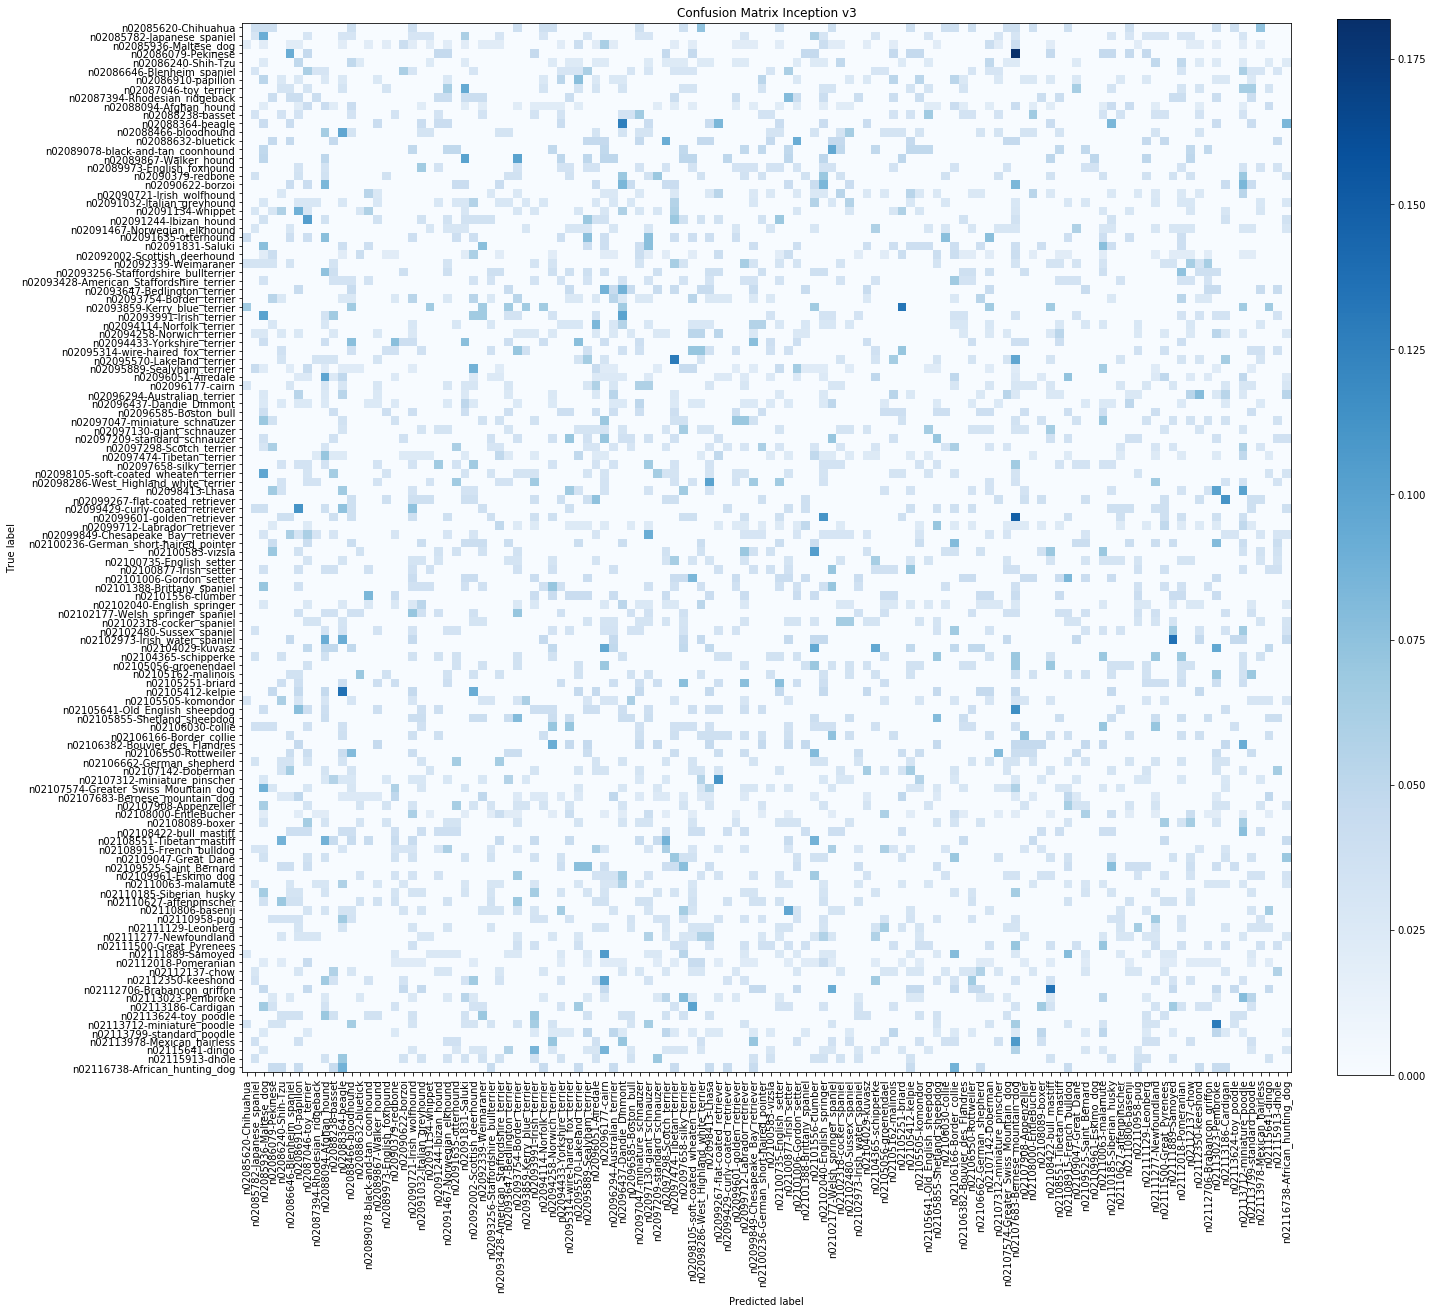

In [38]:
conf_mat = metrics.confusion_matrix(y_true, y_pred)
dog_breeds = dog_breeds
plot_confusion_matrix(conf_mat, dog_breeds, normalize=True, title='Confusion Matrix Inception v3')

In [19]:
from keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def final_predict(img_path, topk = 3):
    
    # obtain predicted vector
    
    predicted_vector = model.predict(preprocess_input(path_to_tensor(img_path)))
    
    # return dog breed that is predicted by the model
    # print(dog_names[np.argmax(predicted_vector)])
    results = sorted(enumerate(predicted_vector[0]), reverse=True, key=lambda x:x[1])
    classes_ind = [x[0] for x in results]
    classes = [dog_names[x] for x in classes_ind][:topk]
    probs = [x[1] for x in results][:topk]
    
    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    img = mpimg.imread(img_path)
    ax1.imshow(img)
    
    ind = np.arange(len(classes))
    ax2.bar(ind, probs, align='center', alpha = .75)
    ax2.set_xticks(ind)
    ax2.set_xticklabels(classes, rotation=90)

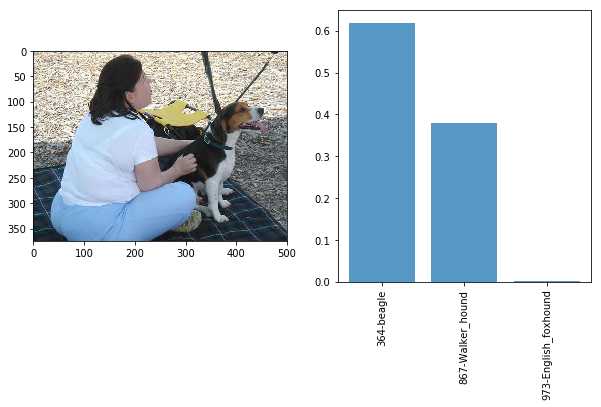

In [24]:
final_predict('../data/validation/n02088364-beagle/7.jpg')